In [5]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')  # enable import from src/

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import json
import pickle
from copy import deepcopy
from pathlib import Path

import gurobipy
from gurobipy import GRB
import dgl
import numpy as np
import torch
import matplotlib.pyplot as plt

from src.problem import get_model
from src.dataset import MultiTargetDataset
from src.net import InstanceGCN
from src.utils import load_from_wandb

In [4]:
instances_dir = Path('../data/raw')
instances_fpaths = list(instances_dir.glob('97_*.json'))

net = InstanceGCN(1, readout_op=None)
net = load_from_wandb(net, 'vty6z1q3', 'sat-gnn', 'model_last')
net.eval()

ds = MultiTargetDataset(instances_fpaths, split='val', return_model=True)

RuntimeError: Error(s) in loading state_dict for InstanceGCN:
	Missing key(s) in state_dict: "convs.0.mods.v2c.fc_pool.weight", "convs.0.mods.v2c.fc_pool.bias", "convs.0.mods.v2c.fc_neigh.weight", "convs.0.mods.v2c.fc_self.weight", "convs.0.mods.v2c.fc_self.bias", "convs.0.mods.s2c.fc_pool.weight", "convs.0.mods.s2c.fc_pool.bias", "convs.0.mods.s2c.fc_neigh.weight", "convs.0.mods.s2c.fc_self.weight", "convs.0.mods.s2c.fc_self.bias", "convs.0.mods.c2v.fc_pool.weight", "convs.0.mods.c2v.fc_pool.bias", "convs.0.mods.c2v.fc_neigh.weight", "convs.0.mods.c2v.fc_self.weight", "convs.0.mods.c2v.fc_self.bias", "convs.0.mods.c2s.fc_pool.weight", "convs.0.mods.c2s.fc_pool.bias", "convs.0.mods.c2s.fc_neigh.weight", "convs.0.mods.c2s.fc_self.weight", "convs.0.mods.c2s.fc_self.bias", "convs.1.mods.v2c.fc_pool.weight", "convs.1.mods.v2c.fc_pool.bias", "convs.1.mods.v2c.fc_neigh.weight", "convs.1.mods.v2c.fc_self.weight", "convs.1.mods.v2c.fc_self.bias", "convs.1.mods.s2c.fc_pool.weight", "convs.1.mods.s2c.fc_pool.bias", "convs.1.mods.s2c.fc_neigh.weight", "convs.1.mods.s2c.fc_self.weight", "convs.1.mods.s2c.fc_self.bias", "convs.1.mods.c2v.fc_pool.weight", "convs.1.mods.c2v.fc_pool.bias", "convs.1.mods.c2v.fc_neigh.weight", "convs.1.mods.c2v.fc_self.weight", "convs.1.mods.c2v.fc_self.bias", "convs.1.mods.c2s.fc_pool.weight", "convs.1.mods.c2s.fc_pool.bias", "convs.1.mods.c2s.fc_neigh.weight", "convs.1.mods.c2s.fc_self.weight", "convs.1.mods.c2s.fc_self.bias". 
	Unexpected key(s) in state_dict: "convs.0.mods.v2c.weight", "convs.0.mods.v2c.bias", "convs.0.mods.s2c.weight", "convs.0.mods.s2c.bias", "convs.0.mods.c2v.weight", "convs.0.mods.c2v.bias", "convs.0.mods.c2s.weight", "convs.0.mods.c2s.bias", "convs.1.mods.v2c.weight", "convs.1.mods.v2c.bias", "convs.1.mods.s2c.weight", "convs.1.mods.s2c.bias", "convs.1.mods.c2v.weight", "convs.1.mods.c2v.bias", "convs.1.mods.c2s.weight", "convs.1.mods.c2s.bias". 
	size mismatch for soc_emb.0.weight: copying a param with shape torch.Size([10, 1]) from checkpoint, the shape in current model is torch.Size([64, 6]).
	size mismatch for soc_emb.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for var_emb.0.weight: copying a param with shape torch.Size([10, 1]) from checkpoint, the shape in current model is torch.Size([64, 1]).
	size mismatch for var_emb.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for con_emb.0.weight: copying a param with shape torch.Size([10, 2]) from checkpoint, the shape in current model is torch.Size([64, 4]).
	size mismatch for con_emb.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for output.0.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for output.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for output.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for output.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for output.4.weight: copying a param with shape torch.Size([1, 10]) from checkpoint, the shape in current model is torch.Size([1, 64]).

# Warm start

In [7]:
def get_ws_times_n_vars(graph, model, net, name=None, plot=True, timeout=60):
    vars_names = np.core.defchararray.array([v.getAttr(GRB.Attr.VarName) for v in model.getVars()])
    vars_names = vars_names[(vars_names.find('x(') >= 0) | (vars_names.find('phi(') >= 0)]

    # baseline results
    model_ = model.copy()
    model_.setParam('TimeLimit', timeout)
    model_.update()
    model_.optimize()
    baseline_runtime = model_.Runtime
    baseline_obj = model_.ObjVal
    baseline_gap = model_.MIPGap

    with torch.no_grad():
        x_hat = torch.sigmoid(net(graph)).squeeze(0)

    most_certain_idx  = (x_hat - 0.5).abs().sort(descending=True).indices


    runtimes = list()
    objs = list()
    gaps = list()
    ns = list()
    for n in [0, 50, 100, 200, 500, 1000, len(x_hat)]:
    # for n in [0, 50, 100, 150]:
        if n == 0:
            runtimes.append(baseline_runtime)
            objs.append(baseline_obj)
            gaps.append(baseline_gap)
            ns.append(n)
            continue

        fixed_x_hat = (x_hat[most_certain_idx[:n]] > .5).to(x_hat)
        fixed_vars_names = vars_names[most_certain_idx[:n]]

        # fix variables
        model_ = model.copy()
        for fixed_var_name, fixed_var_X in zip(fixed_vars_names, fixed_x_hat):
            model_.getVarByName(fixed_var_name).Start = fixed_var_X

        model_.setParam('TimeLimit', timeout)
        model_.update()
        model_.optimize()

        if model_.status not in [2, 9]:
            print('warm starting with n=',n,' made the optimizatio terminate with status ',model_.status)
            break

        runtimes.append(model_.Runtime)
        objs.append(model_.ObjVal)
        gaps.append(model_.MIPGap)
        ns.append(n)

    objs = [100 * o / baseline_obj for o in objs]

    if plot:
        fig, ax = plt.subplots()
        ax.plot(ns, runtimes, '.-', label='Runtime')
        # ax.set_xlim((0, x_opt.shape[0]))
        ax.grid()
        ax.legend(loc=1)

        ax.set_title('Early fixing performance '+str(name))
        ax.set_xlabel('# fixed variables')
        ax.set_ylabel('Runtime')

        ax.set_xlim(0,max(ns))

        obj_ax = ax.twinx()
        obj_ax.plot(ns, objs, '.-', c='r', label='Objective')
        obj_ax.legend(loc=4)
        obj_ax.set_ylim(min(objs), 100)
        obj_ax.set_ylabel('Objective')

        fig.show()

    return ns, runtimes, objs, gaps

In [10]:
g, _, m = ds[-1]

ns, runtimes, objs, gaps = get_ws_times_n_vars(g, m, net, timeout=10, plot=False)
ns, runtimes, objs, gaps

([0, 50, 100, 200, 500, 1000, 1746],
 [0.840144157409668,
  0.5113790035247803,
  1.2048890590667725,
  0.6877460479736328,
  0.6777899265289307,
  0.8448271751403809,
  0.6791079044342041],
 [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

# Hinting

In [14]:
m.getVars()[0].VarHintPri

0

In [15]:
def get_ht_times_n_vars(graph, model, net, name=None, plot=True, timeout=60):
    vars_names = np.core.defchararray.array([v.getAttr(GRB.Attr.VarName) for v in model.getVars()])
    vars_names = vars_names[(vars_names.find('x(') >= 0) | (vars_names.find('phi(') >= 0)]

    # baseline results
    model_ = model.copy()
    model_.setParam('TimeLimit', timeout)
    model_.update()
    model_.optimize()
    baseline_runtime = model_.Runtime
    baseline_obj = model_.ObjVal
    baseline_gap = model_.MIPGap

    with torch.no_grad():
        x_hat = torch.sigmoid(net(graph)).squeeze(0)

    most_certain_idx  = (x_hat - 0.5).abs().sort(descending=True).indices


    runtimes = list()
    objs = list()
    gaps = list()
    ns = list()
    for n in [0, 50, 100, 200, 500, 1000, len(x_hat)]:
    # for n in [0, 50, 100, 150]:
        if n == 0:
            runtimes.append(baseline_runtime)
            objs.append(baseline_obj)
            gaps.append(baseline_gap)
            ns.append(n)
            continue

        fixed_x_hat = (x_hat[most_certain_idx[:n]] > .5).to(x_hat)
        certainty_x_hat = (x_hat[most_certain_idx[:n]] - 0.5).abs() * 2
        fixed_vars_names = vars_names[most_certain_idx[:n]]

        # fix variables
        model_ = model.copy()
        for fixed_var_name, fixed_var_X, var_certainty in zip(fixed_vars_names, fixed_x_hat, certainty_x_hat):
            model_.getVarByName(fixed_var_name).VarHintVal = fixed_var_X
            model_.getVarByName(fixed_var_name).VarHintPri = int(var_certainty * 100)

        model_.setParam('TimeLimit', timeout)
        model_.update()
        model_.optimize()

        if model_.status not in [2, 9]:
            print('warm starting with n=',n,' made the optimizatio terminate with status ',model_.status)
            break

        runtimes.append(model_.Runtime)
        objs.append(model_.ObjVal)
        gaps.append(model_.MIPGap)
        ns.append(n)

    objs = [100 * o / baseline_obj for o in objs]

    if plot:
        fig, ax = plt.subplots()
        ax.plot(ns, runtimes, '.-', label='Runtime')
        # ax.set_xlim((0, x_opt.shape[0]))
        ax.grid()
        ax.legend(loc=1)

        ax.set_title('Early fixing performance '+str(name))
        ax.set_xlabel('# fixed variables')
        ax.set_ylabel('Runtime')

        ax.set_xlim(0,max(ns))

        obj_ax = ax.twinx()
        obj_ax.plot(ns, objs, '.-', c='r', label='Objective')
        obj_ax.legend(loc=4)
        obj_ax.set_ylim(min(objs), 100)
        obj_ax.set_ylabel('Objective')

        fig.show()

    return ns, runtimes, objs, gaps

In [19]:
g, _, m = ds[2]

ns, runtimes, objs, gaps = get_ht_times_n_vars(g, m, net, timeout=10, plot=False)
ns, runtimes, objs, gaps

([0, 50, 100, 200, 500, 1000, 4268],
 [10.009244918823242,
  10.007880210876465,
  10.005330085754395,
  10.010838031768799,
  10.027592182159424,
  10.018505096435547,
  10.02341604232788],
 [100.0,
  99.77518904557532,
  99.74453300633559,
  99.64234620886981,
  99.77518904557532,
  99.77518904557532,
  99.77518904557532],
 [0.05773554056815859,
  0.06421548545678,
  0.06669398627189838,
  0.06573684750282022,
  0.06278164686603852,
  0.06411306841458418,
  0.06329373207701762])

# All results

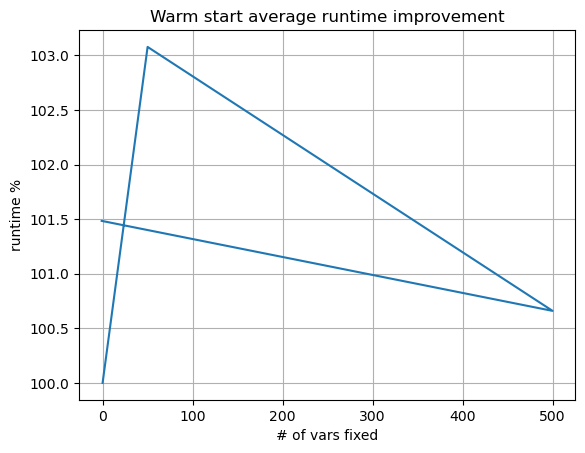

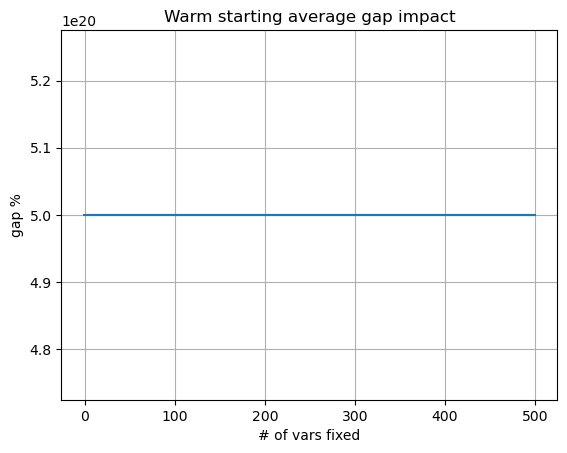

In [12]:
from collections import OrderedDict

with open('../scip_ws_performance_tpdkvk0w.pkl', 'rb') as f:
    ws_perfs = pickle.load(f)

ns = [0, 50, 500, -1]

runtimes = OrderedDict([(n, list()) for n in ns])
gaps = OrderedDict([(n, list()) for n in ns])

for ws_perf in ws_perfs:
    if ws_perf['J'] > 9:
        continue

    for i in range(len(ws_perf['ns'])):
        if ws_perf['gaps'][i] < np.inf:
            runtimes[ns[i]].append(ws_perf['runtimes'][i] / ws_perf['runtimes'][0])
            gaps[ns[i]].append(ws_perf['gaps'][i])

mean_runtimes = np.array([sum(runtimes[n]) / len(runtimes[n]) for n in ns if len(runtimes[n]) != 0])
max_runtimes = np.array([max(runtimes[n]) for n in ns if len(runtimes[n]) != 0])
min_runtimes = np.array([min(runtimes[n]) for n in ns if len(runtimes[n]) != 0])

plt.plot(ns[:len(mean_runtimes)], mean_runtimes * 100)
# plt.fill_between(ns[:len(mean_runtimes)], min_runtimes * 100, max_runtimes * 100, alpha=0.5)
plt.title('Warm start average runtime improvement')
plt.xlabel('# of vars fixed')
plt.ylabel('runtime %')
# plt.yscale('log')
plt.grid()
plt.show()

mean_gaps = np.array([sum(gaps[n]) / len(gaps[n]) for n in ns if len(gaps[n]) != 0])

plt.plot(ns[:len(mean_gaps)], 100*mean_gaps)
# plt.fill_between(ns[:len(mean_runtimes)], min_runtimes * 100, max_runtimes * 100, alpha=0.5)
plt.title('Warm starting average gap impact')
plt.xlabel('# of vars fixed')
plt.ylabel('gap %')
# plt.yscale('log')
plt.grid()
plt.show()

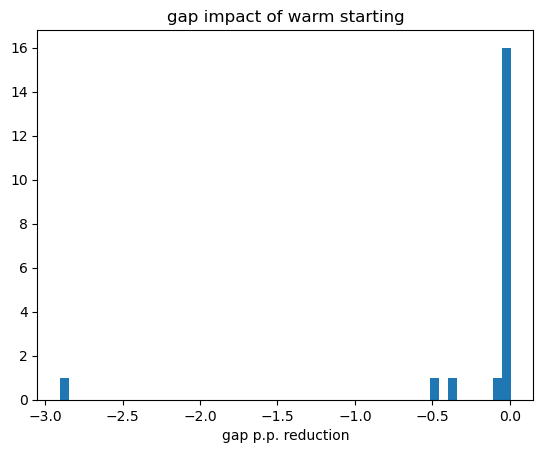

In [5]:
plt.hist(100*(np.array(gaps[0]) - np.array(gaps[-1])), bins=50)
plt.title('gap impact of warm starting')
plt.xlabel('gap p.p. reduction')
plt.show()

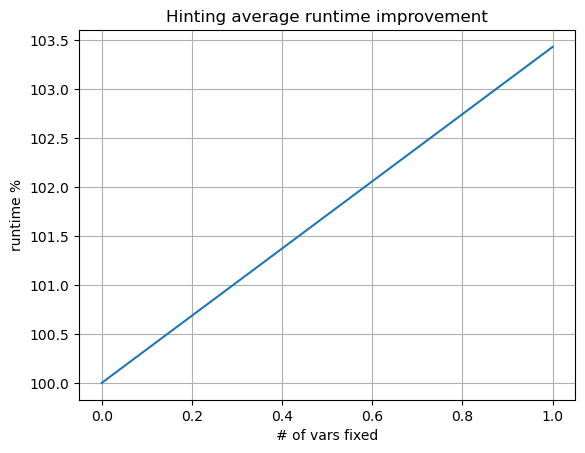

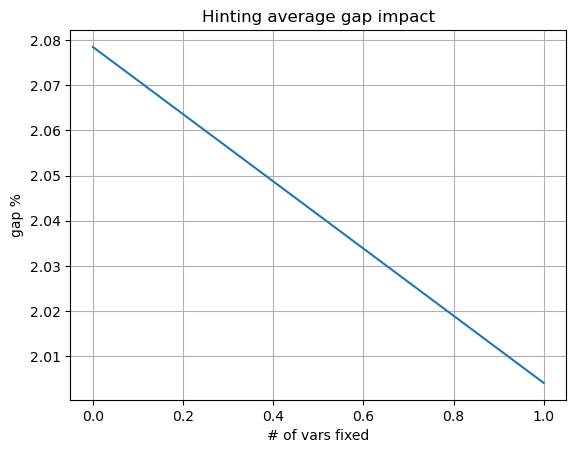

In [56]:
from collections import OrderedDict

with open('../ht_performance_h461hez1.pkl', 'rb') as f:
    ht_perfs = pickle.load(f)

ns = [0, 1]

runtimes = OrderedDict([(n, list()) for n in ns])
gaps = OrderedDict([(n, list()) for n in ns])

for ws_perf in ht_perfs:
    for i in range(len(ws_perf['ns'])):
        if ws_perf['gaps'][i] < np.inf:
            runtimes[ns[i]].append(ws_perf['runtimes'][i] / ws_perf['runtimes'][0])
            gaps[ns[i]].append(ws_perf['gaps'][i])

mean_runtimes = np.array([sum(runtimes[n]) / len(runtimes[n]) for n in ns if len(runtimes[n]) != 0])
max_runtimes = np.array([max(runtimes[n]) for n in ns if len(runtimes[n]) != 0])
min_runtimes = np.array([min(runtimes[n]) for n in ns if len(runtimes[n]) != 0])

plt.plot(ns[:len(mean_runtimes)], mean_runtimes * 100)
# plt.fill_between(ns[:len(mean_runtimes)], min_runtimes * 100, max_runtimes * 100, alpha=0.5)
plt.title('Hinting average runtime improvement')
plt.xlabel('# of vars fixed')
plt.ylabel('runtime %')
# plt.yscale('log')
plt.grid()
plt.show()

mean_gaps = np.array([sum(gaps[n]) / len(gaps[n]) for n in ns if len(gaps[n]) != 0])

plt.plot(ns[:len(mean_gaps)], 100*mean_gaps)
# plt.fill_between(ns[:len(mean_runtimes)], min_runtimes * 100, max_runtimes * 100, alpha=0.5)
plt.title('Hinting average gap impact')
plt.xlabel('# of vars fixed')
plt.ylabel('gap %')
# plt.yscale('log')
plt.grid()
plt.show()